In [2]:
import pandas as pd
import os, re, glob, shutil

In [3]:
current_dir = os.getcwd()
start_kit_dir = current_dir + '/start_kit'

Load the `json` into DataFrame.

In [4]:
json_dir = start_kit_dir +'/WLASL_v0.3.json'

df = pd.read_json(json_dir)
df_exploded = df.explode("instances", ignore_index=True)
df_flat = pd.concat(
    [df_exploded.drop(columns=["instances"]),
     pd.json_normalize(df_exploded["instances"])],
    axis=1
)
df_flat.head()

,gloss,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id
0,book,"[385, 37, 885, 720]",25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241
1,book,"[190, 25, 489, 370]",25,-1,1,1,90,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,65225
2,book,"[262, 1, 652, 480]",25,-1,1,2,110,valencia-asl,train,https://www.youtube.com/watch?v=0UsjUE-TXns,0,68011
3,book,"[123, 19, 516, 358]",25,60,1,3,113,lillybauer,train,https://www.youtube.com/watch?v=1QOYOZ3g-aY,0,68208
4,book,"[95, 0, 1180, 720]",25,-1,1,4,109,valencia-asl,train,https://www.youtube.com/watch?v=aGtIHKEdCds,0,68012


In [5]:
df_flat.columns.to_list()

['gloss',
 'bbox',
 'fps',
 'frame_end',
 'frame_start',
 'instance_id',
 'signer_id',
 'source',
 'split',
 'url',
 'variation_id',
 'video_id']

## 1 Exploratory Data Analysis on JSON

In [10]:
df_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21083 entries, 0 to 21082
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   gloss         21083 non-null  object
 1   bbox          21083 non-null  object
 2   fps           21083 non-null  int64 
 3   frame_end     21083 non-null  int64 
 4   frame_start   21083 non-null  int64 
 5   instance_id   21083 non-null  int64 
 6   signer_id     21083 non-null  int64 
 7   source        21083 non-null  object
 8   split         21083 non-null  object
 9   url           21083 non-null  object
 10  variation_id  21083 non-null  int64 
 11  video_id      21083 non-null  object
dtypes: int64(6), object(6)
memory usage: 1.9+ MB


Q1: Find out the total number of videos in this dataset.

In [11]:
print(f"Total number of videos: {df_flat.shape[0]}")

Total number of videos: 21083


Q2: How many glosses are there in this dataset?

In [12]:
print(f"Total number of glosses: {df_flat['gloss'].unique().shape[0]}")

Total number of glosses: 2000


Q3: Which are the top-N most frequent gloss?

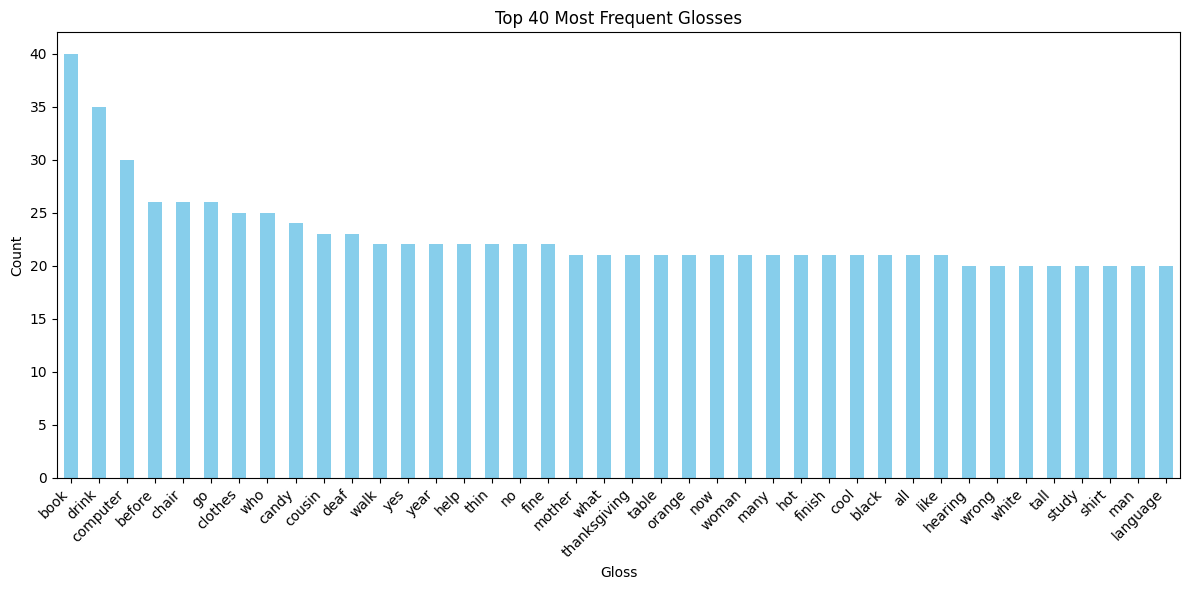

In [13]:
import matplotlib.pyplot as plt

gloss_counts = df_flat["gloss"].value_counts()

top_n = 40
gloss_counts.head(top_n).plot(kind="bar", figsize=(12,6), color="skyblue")
plt.title(f"Top {top_n} Most Frequent Glosses")
plt.xlabel("Gloss")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Q4: Which are the top-N most frequent gloss?

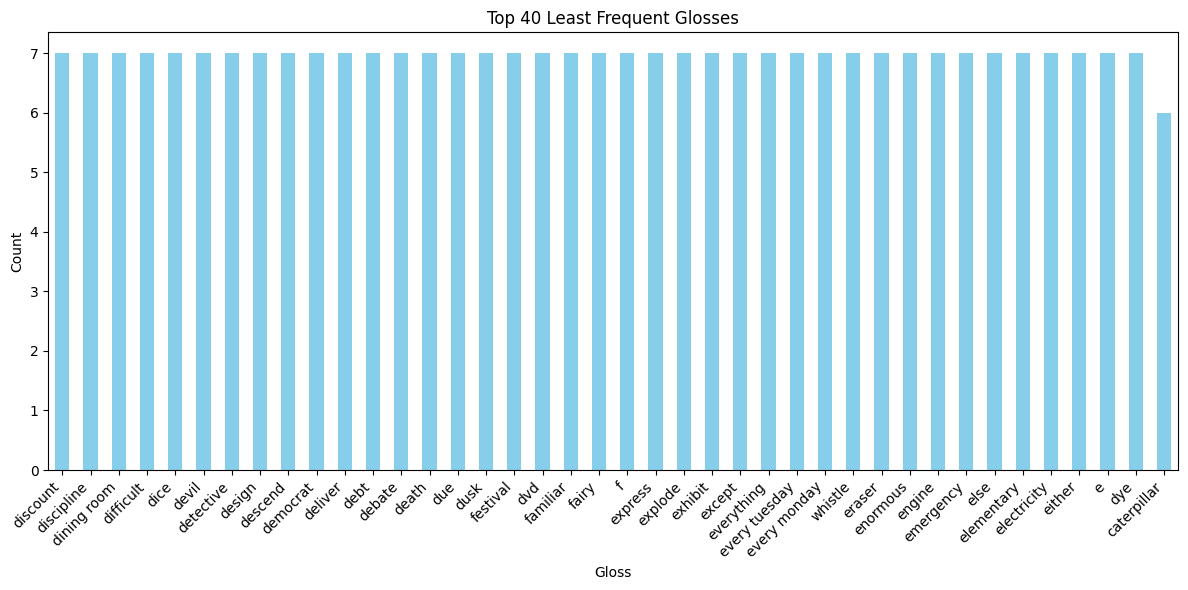

In [25]:
import matplotlib.pyplot as plt

gloss_counts = df_flat["gloss"].value_counts()

top_n = 40
gloss_counts.tail(top_n).plot(kind="bar", figsize=(12,6), color="skyblue")
plt.title(f"Top {top_n} Least Frequent Glosses")
plt.xlabel("Gloss")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [27]:
video_dir = start_kit_dir + '/raw_videos_mp4'
videos = glob.glob(os.path.join(video_dir, "*.mp4"))
print("Total number of videos: ", len(videos))

Total number of videos:  11031


Construct the dataframe and fetch their gloss.

In [28]:
data = []
for video_url in videos:
    video_id = os.path.splitext(os.path.basename(video_url))[0]
    data.append({"video_id": video_id, "video_url": video_url})

video_df = pd.DataFrame(data, columns=["video_id", "video_url"])

In [ ]:
def extract_yt_id(url):
    if url.startswith("https://youtu.be/"):
        return url.split('/')[-1]  # everything after last /
    elif url.startswith("https://www.youtube.com/watch?v="):
        return url.split('v=')[-1]  # everything after v=
    else:
        return None

In [29]:
youtube_df = df_flat[df_flat['url'].str.startswith(('https://youtu.be/', 'https://www.youtube.com/watch?v='))]
youtube_df = youtube_df[['video_id', 'gloss', 'url']]
youtube_df['filename'] = youtube_df['url'].apply(extract_yt_id)

video_id_map = dict(zip(youtube_df['filename'], youtube_df['video_id']))
video_df['video_id'] = video_df['video_id'].map(lambda x: video_id_map.get(x, x))

In [30]:
video_df = pd.merge(video_df, df_flat[['gloss', 'video_id']], on='video_id', how='left')
video_df.head(5)

,video_id,video_url,gloss
0,17533,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,dragon
1,52291,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,slave
2,34114,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,lousy
3,60545,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,understand
4,17915,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,drunk


Q1: Which are the top-N most frequent gloss?

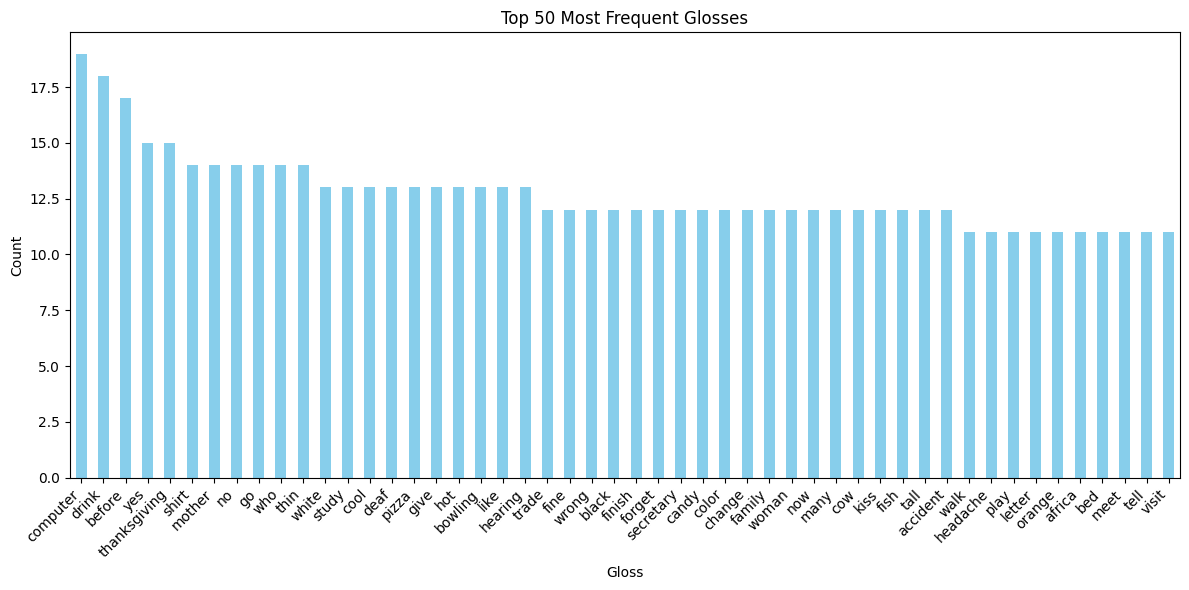

In [55]:
import matplotlib.pyplot as plt

gloss_counts = video_df["gloss"].value_counts()

top_n = 50
gloss_counts.head(top_n).plot(kind="bar", figsize=(12,6), color="skyblue")
plt.title(f"Top {top_n} Most Frequent Glosses")
plt.xlabel("Gloss")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 2 Exploratory Data Analysis on processed videos

In [6]:
video_dir = start_kit_dir + '/videos_full'
videos = glob.glob(os.path.join(video_dir, "*.mp4"))
print("Total number of videos: ", len(videos))

Total number of videos:  15859


In [19]:
data = []
for video_url in videos:
    video_id = os.path.splitext(os.path.basename(video_url))[0]
    data.append({"video_id": video_id, "video_url": video_url})

video_df = pd.DataFrame(data, columns=["video_id", "video_url"])

In [21]:
video_df = video_df.merge(
    df_flat[['video_id', 'gloss']],
    on='video_id',
    how='left'
)
video_df

,video_id,video_url,gloss
0,52291,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,slave
1,54838,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,stitch
2,34114,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,lousy
3,60545,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,understand
4,17915,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,drunk
...,...,...,...
15854,43385,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,pocket
15855,23471,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,french fries
15856,52288,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,slave
15857,54821,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,stink


Q1: Which are the top-N most frequent gloss?

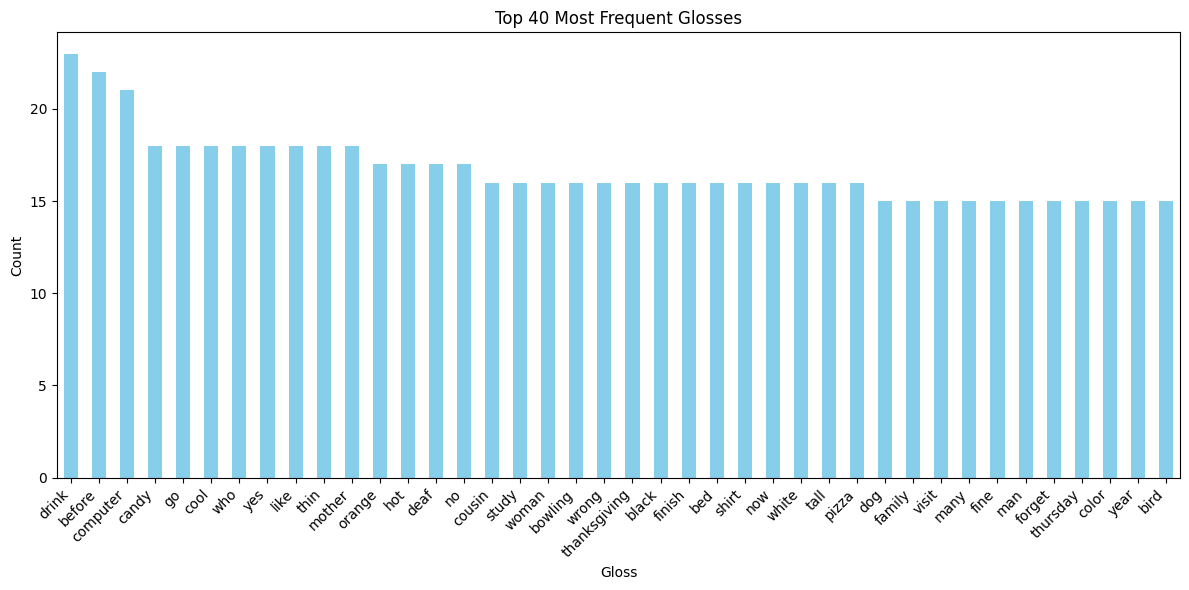

In [26]:
import matplotlib.pyplot as plt

gloss_counts = video_df["gloss"].value_counts()

top_n = 40
gloss_counts.head(top_n).plot(kind="bar", figsize=(12,6), color="skyblue")
plt.title(f"Top {top_n} Most Frequent Glosses")
plt.xlabel("Gloss")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Q2: Which are the top-N least frequent gloss?

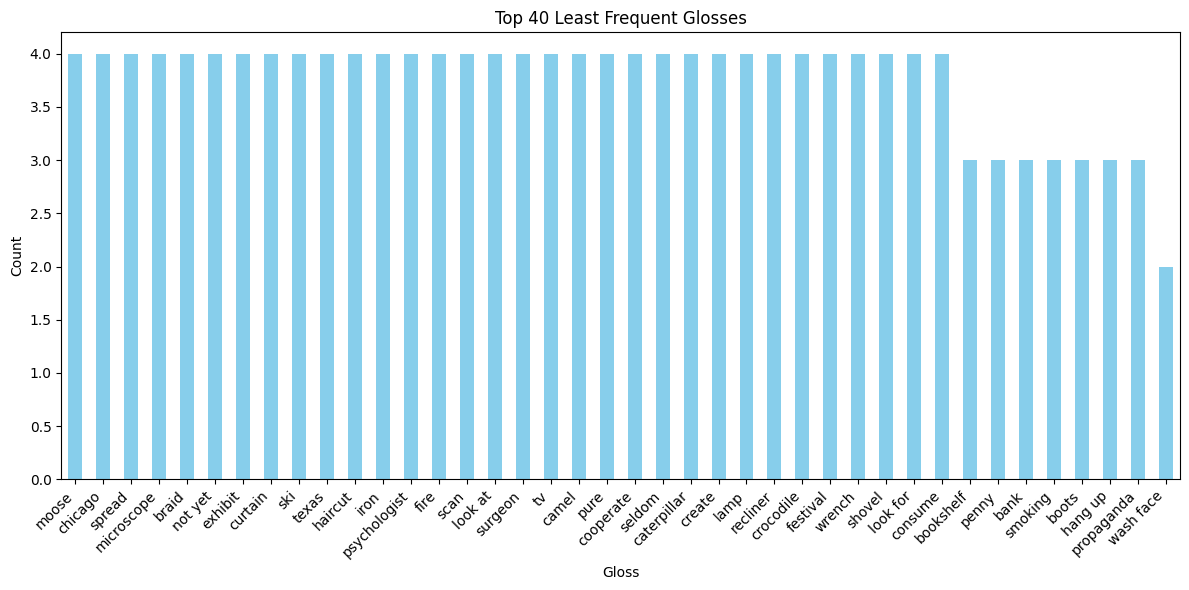

In [24]:
import matplotlib.pyplot as plt

gloss_counts = video_df["gloss"].value_counts()

top_n = 40
gloss_counts.tail(top_n).plot(kind="bar", figsize=(12,6), color="skyblue")
plt.title(f"Top {top_n} Least Frequent Glosses")
plt.xlabel("Gloss")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Download the distribution as excel to your local machine.

In [32]:
video_df['gloss'].value_counts().reset_index().to_excel('distribution.xlsx', index=False)

## Developer Used Only

### Trace the progress of `log` file

The code below will allow us to read the log file.

In [9]:
with open(f"{current_dir}/start_kit/download_1762824035.log", "r") as f:
    lines = f.readlines()

log_df = pd.DataFrame({"raw": [line.strip() for line in lines]})
log_df["level"] = log_df["raw"].str.extract(r"^(INFO|ERROR|WARNING)")
log_df["gloss"] = log_df["raw"].str.extract(r"gloss:\s*(\w+)")
log_df["video_id"] = log_df["raw"].str.extract(r"video:?\s*(\d+)")
log_df["url"] = log_df["raw"].str.extract(r"(https?://\S+)")
log_df["message"] = log_df["raw"].str.extract(r"root:(.*)")

log_df.tail()

,raw,level,gloss,video_id,url,message
37267,ERROR:root:Unsuccessful downloading - video 39119,ERROR,NaN,39119,NaN,Unsuccessful downloading - video 39119
37268,"INFO:root:gloss: over, video: 40559.",INFO,over,40559,NaN,"gloss: over, video: 40559."
37269,INFO:root:Requesting https://media.spreadthesi...,INFO,NaN,NaN,https://media.spreadthesign.com/video/mp4/13/3...,Requesting https://media.spreadthesign.com/vid...
37270,"INFO:root:gloss: over, video: 40568.",INFO,over,40568,NaN,"gloss: over, video: 40568."
37271,INFO:root:Requesting http://www.aslpro.com/mai...,INFO,NaN,NaN,http://www.aslpro.com/main/o/over.swf,Requesting http://www.aslpro.com/main/o/over.swf


### Locate the latest row based on `video_id`.

In [10]:
df_flat[df_flat["video_id"] == log_df['video_id'].dropna().iloc[-1]]

,gloss,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id
17239,over,"[17, 17, 233, 240]",25,-1,1,2,87,aslpro,test,http://www.aslpro.com/main/o/over.swf,0,40568


### Compare `videos` and `videos_kaggle`

In [59]:
videos = glob.glob(os.path.join(start_kit_dir+'/videos', "*.mp4"))
kaggle = glob.glob(os.path.join(start_kit_dir+'/videos_kaggle', "*.mp4"))

print(f"Total number of videos: {len(videos)}/{len(kaggle)}")

Total number of videos: 12916/11980


In [60]:
data = []
for video_url in videos:
    video_id = os.path.splitext(os.path.basename(video_url))[0]
    data.append({"video_id": video_id, "video_url": video_url})

video_df = pd.DataFrame(data, columns=["video_id", "video_url"])

In [61]:
data = []
for video_url in kaggle:
    video_id = os.path.splitext(os.path.basename(video_url))[0]
    data.append({"video_id": video_id, "video_url": video_url})

kaggle_df = pd.DataFrame(data, columns=["video_id", "video_url"])

video only in source dataset.

In [68]:
kaggle_ids = kaggle_df['video_id'].unique()
video_df[~video_df['video_id'].isin(kaggle_ids)].sort_values(['video_id'])

,video_id,video_url
12144,00295,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...
10048,00333,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...
6037,00374,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...
6031,00412,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...
6741,00422,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...
...,...,...
11505,70375,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...
12355,70376,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...
12651,70377,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...
1334,70378,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...


video only in kaggle dataset.

In [67]:
video_ids = video_df['video_id'].unique()
kaggle_df[~kaggle_df['video_id'].isin(video_ids)].sort_values(['video_id'])

,video_id,video_url
8528,00341,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...
6960,00384,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...
8564,00426,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...
6991,00435,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...
4203,00603,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...
...,...,...
6747,66820,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...
7329,66821,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...
6580,66822,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...
7469,66825,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...


### Combine both scripted and kaggle dataset

Copy those video exists only in kaggle into `videos_full` folder.

In [71]:
os.makedirs(start_kit_dir + "/videos_full", exist_ok=True)
discrepant_videos = kaggle_df[~kaggle_df["video_id"].isin(video_df["video_id"])]
print(f"Found {len(discrepant_videos)} videos to copy.")

for _, row in discrepant_videos.iterrows():
    src = row["video_url"]
    dst = os.path.join(start_kit_dir + "/videos_full", os.path.basename(src))

    if os.path.exists(src):
        shutil.copy2(src, dst)
    else:
        print(f"Missing: {src}")

Found 2943 videos to copy.


In [72]:
video_dir = start_kit_dir + '/videos_full'
full = glob.glob(os.path.join(video_dir, "*.mp4"))

data = []
for video_url in full:
    video_id = os.path.splitext(os.path.basename(video_url))[0]
    data.append({"video_id": video_id, "video_url": video_url})

full_df = pd.DataFrame(data, columns=["video_id", "video_url"])
full_df = pd.merge(full_df, df_flat[['gloss', 'video_id']], on='video_id', how='left')

In [76]:
full_df

,video_id,video_url,gloss
0,52291,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,slave
1,54838,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,stitch
2,34114,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,lousy
3,60545,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,understand
4,17915,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,drunk
...,...,...,...
15854,43385,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,pocket
15855,23471,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,french fries
15856,52288,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,slave
15857,54821,/Users/zychee/Downloads/wlasl/WLASL/start_kit/...,stink


### Organize the videos into folder by gloss.

In [52]:
output_dir = start_kit_dir + '/categorized'
os.makedirs(output_dir, exist_ok=True)

for idx, row in video_df.iterrows():
    gloss = row['gloss']
    video_path = row['video_url']
    video_id = row['video_id']
    
    if pd.isna(gloss):
        continue  # skip videos without gloss
    
    # Folder for each gloss
    gloss_folder = os.path.join(output_dir, gloss)
    os.makedirs(gloss_folder, exist_ok=True)
    
    # Destination path
    dest_path = os.path.join(gloss_folder, video_id+'.mp4')
    
    # Move or copy video
    shutil.copy(video_path, dest_path)